In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [302]:
from deepy.dataset import mnist

In [303]:
(X_train, y_train), (X_test, y_test) = mnist.load_mnist(flatten=False, normalize=False)

In [304]:
X_train.shape

(60000, 1, 28, 28)

In [305]:
# 디자인 매트릭스로 reshape하기
X_train = X_train.reshape(-1, 1*28*28)
X_test = X_test.reshape(-1, 1*28*28)

In [306]:
X_train.dtype, X_train.max()

(dtype('uint8'), 255)

In [307]:
# Perceptron은 단위에 민감함.
X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0

X_train.dtype, X_train.max()

(dtype('float64'), 1.0)

### 데이터에 대해 처음으로 적용할 만한 모델은 선형모델입니다.
- 선형모델로 테스트해보고 이 문제는 비선형으로 해결해야 겠다고 판단되면 그때 결정트리를 선택하든 신경망 등을 선택해서 처리하는 사고를 해야 함.

In [308]:
# 분류의 문제라서 Regression을 사용함.
from sklearn.linear_model import SGDClassifier

In [309]:
logreg = SGDClassifier(loss='log', tol=1e-4).fit(X_train, y_train)

In [310]:
logreg.score(X_train, y_train)

0.92075

In [311]:
logreg.score(X_test, y_test)

0.9163

In [312]:
from sklearn.ensemble import RandomForestClassifier

In [313]:
forest = RandomForestClassifier().fit(X_train, y_train)

In [314]:
forest.score(X_train, y_train)

0.9991833333333333

In [315]:
forest.score(X_test, y_test)

0.9471

In [316]:
# 기계학습 vs 딥러닝의 차이
# 딥러닝: 종단간의 기계 학습
# 기계학습에서는 특징을 뽑아서 변환함수를 만드는데 엄청 실혈을 기울인다.
# 확장성이 무족하다. 
# 99.xxx까지 정확도가 올라가려면 딥러닝이 필요하게 됨.

In [317]:
# "학습": 손실함수 최적화
# 손실이 큰지 아닌지는 미분하여 기울기로 알 수 있음.

# 손실함수

In [318]:
# mean_squared_error(평균제곱오차): 회귀영 손실함수
def mse(y_pred, y):
    """회귀용 손실함수"""
    return 0.5 * np.sum((y-y_pred)**2)

In [319]:
# 정답에서 멀어질 수록 mse가 커진다.
y = 1.2
mse(0.5, y), mse(1.1, y), mse(1.2, y)

(0.24499999999999997, 0.004999999999999987, 0.0)

In [320]:
# cross_entropy_error: 교차엔트로피오차
def cross_entropy_error(y_pred, y):
    """분류용 손실함수"""
    delta = 1e-7 # 0이 되지 않는 아~~~주 작은 값. log에서는 0은 무한대라서 이를 방지하기 위함임.
    return -np.sum(y * np.log(y_pred + delta))

def cross_entropy_error_batch(y_pred, y):
    batch_size = len(y)
    return cross_entropy_error(y_pred, y) / batch_size

In [321]:
y = np.array([0, 1, 0])
label = np.argmax(y)
label

1

In [322]:
y_pred1 = np.array([0.1, 0.7, 0.2])
y_pred2 = np.array([0.7, 0.1, 0.2])
y_pred3 = np.array([0.2, 0.6, 0.2])

In [323]:
cross_entropy_error(y_pred1, y), cross_entropy_error(y_pred2, y), cross_entropy_error(y_pred3, y)

(0.3566748010815999, 2.302584092994546, 0.510825457099338)

In [324]:
# 손실함수 최적화. 미분했을 때 경사를 줄이는 것.

# 손실함수 최적화

x^2
https://www.overleaf.com/learn/latex/Mathematical_expressions

In [325]:
f = lambda x: x**2

In [326]:
# 미분한 값
dydx = lambda x: 2*x

In [327]:
# 수치미분
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [328]:
x = np.linspace(-5., 5., 100)

In [329]:
f(x)

array([2.50000000e+01, 2.40001020e+01, 2.30206101e+01, 2.20615243e+01,
       2.11228446e+01, 2.02045710e+01, 1.93067034e+01, 1.84292419e+01,
       1.75721865e+01, 1.67355372e+01, 1.59192939e+01, 1.51234568e+01,
       1.43480257e+01, 1.35930007e+01, 1.28583818e+01, 1.21441690e+01,
       1.14503622e+01, 1.07769615e+01, 1.01239669e+01, 9.49137843e+00,
       8.87919600e+00, 8.28741965e+00, 7.71604938e+00, 7.16508520e+00,
       6.63452709e+00, 6.12437506e+00, 5.63462912e+00, 5.16528926e+00,
       4.71635547e+00, 4.28782777e+00, 3.87970615e+00, 3.49199061e+00,
       3.12468115e+00, 2.77777778e+00, 2.45128048e+00, 2.14518927e+00,
       1.85950413e+00, 1.59422508e+00, 1.34935211e+00, 1.12488522e+00,
       9.20824406e-01, 7.37169677e-01, 5.73921028e-01, 4.31078461e-01,
       3.08641975e-01, 2.06611570e-01, 1.24987246e-01, 6.37690032e-02,
       2.29568411e-02, 2.55076013e-03, 2.55076013e-03, 2.29568411e-02,
       6.37690032e-02, 1.24987246e-01, 2.06611570e-01, 3.08641975e-01,
      

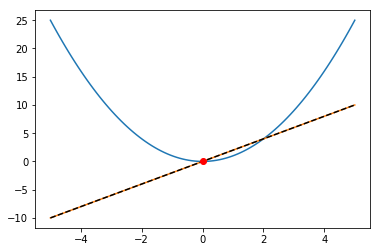

In [330]:
plt.plot(x, f(x))
plt.plot(x, dydx(x))
plt.plot(x, numerical_diff(f, x), 'k--')
plt.plot(0, 0, 'ro')

In [331]:
dydx = lambda x: 2*x

#### latex math
$$ f(x_0, x_1) = x_0^2 + x_1^2 $$

In [332]:
f2 = lambda x: np.sum(x**2, 0)

In [333]:
x0 = np.arange(-5, 5, 0.25)
x1 = np.arange(-5, 5, 0.25)

### 3차원 좌표쌍 생성

In [334]:
X0, X1 = np.meshgrid(x0, x1)

In [335]:
from mpl_toolkits.mplot3d import Axes3D

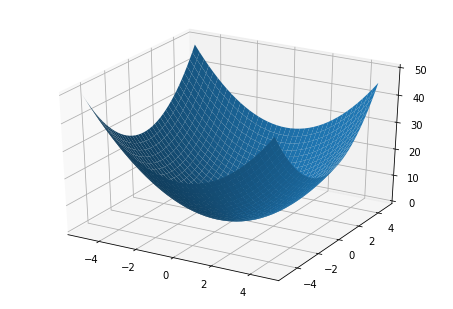

In [336]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X0, X1, f2(np.array([X0, X1])))

### Gradient
기울기

In [337]:
def numerical_gradient(f, x):
    h = 1e-4
    gradient = np.zeros_like(x)
    
    # 각 x 축에 대해 경사 산출(미분 수행)
    for i, xi in enumerate(x):
        # f(x+h)
        x[i] = xi + h
        fxh1 = f(x)
        # f(x-h)
        x[i] = xi - h
        fxh2 = f(x)
        
        gradient[i] = (fxh1 - fxh2) / (2*h)
        # 원래 값 복원
        x[i] = xi

    return gradient

In [338]:
numerical_gradient(f2, np.array([3.0, 4.0])), numerical_gradient(f2, np.array([0.0, 2.0])), numerical_gradient(f2, np.array([3.0, 0.0]))

(array([6., 8.]), array([0., 4.]), array([6., 0.]))

# Gradient Descent(GD)
경사 하강법

$$ \eta  $$

In [339]:
# \eta 는 학습률임. 이 적절한 값은 데이터마다 다르고 작게 해보고 크게 해보면서 조절하면서 알아봐야 함.

In [340]:
def gradient_descent(f, init_x, learning_rate=0.01, iterator=100):
    x = init_x.copy()
    
    x_history = [x.copy()]
    for i in range(iterator):
        gradient = numerical_gradient(f, x)
        # 경사하강
        x -= gradient * learning_rate
        x_history.append(x.copy())
    
    return np.array(x_history)

In [341]:
# 출발점
init_x = np.array([-3., 4.])

x_history = gradient_descent(f2, init_x)

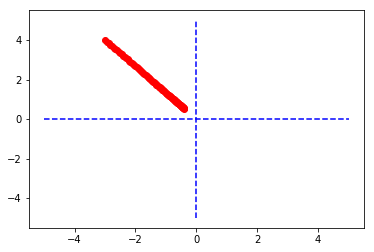

In [342]:
plt.plot(x_history[:, 0], x_history[:, 1], 'ro')
plt.plot([-5, 5], [0, 0], 'b--')
plt.plot([0, 0], [-5, 5], 'b--')

# 신경망 학습

In [373]:
def numerical_gradient_2D(f, X):
    if X.ndim == 1:
        return numerical_gradient(f, x)
    
    # 2차원 행렬인 경우
    gradient = np.zeros_like(X)
    for i, x in enumerate(X):
        gradient[i] = numerical_gradient(f, x)
        
    return gradient
        

# %load neuralnet.py
class Layer:
    def __init__(self, input, output, activate):
        # 신경망에서는 초기값은 0으로 하면 안됨. perceptron은 초기값을 0으로 해도 됨.
        self.W = np.random.randn(input, output)
        self.b = np.random.randn(output)
        self.activate = activate
        
    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        a = self.activate(z)
        return a

class FeedForwardNet:
    def __init__(self, loss_func):
        self.layers = []
        self.loss_func = loss_func
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, X):
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward(layer_output)
        y = layer_output
        return y

    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        loss = self.loss_func(y_pred, y)
        return loss
        
    def fit(self, X, y, batch_size, learning_rate, iterator):
        loss_history = []
        for i in range(iterator):
            ## 1. 미니배치
            sample_count = len(X)
            batch_index = np.random.choice(sample_count, batch_size)
            X_batch = X[batch_index]
            y_batch = y[batch_index]
            
            ## 2. 기울기 산출
            f = lambda W: self.compute_loss(X_batch, y_batch)
            gradient = []
            for layer in self.layers:
                dW = numerical_gradient_2D(f, layer.W)
                db = numerical_gradient_2D(f, layer.b)
                gradient.append((dW, db))
            ## 3. 매개변수 갱신(경사하강법)
            for layer, (dW, db) in zip(self.layers, gradient):
                layer.W -= dW * learning_rate
                layer.b -= db * learning_rate

            # 손실확인
            loss = self.compute_loss(X_batch, y_batch)
            loss_history.append(loss)
            print('[learning {}] Loss {}'.format(i, loss))
            
        return loss_history

In [374]:
# ALT 시간

# Q. 입력과 출력의 관계?
# 선형모델의 양상을 살펴보고 결정트리를 조합해서 살펴봐야 할 것 같다.
# 선형모델이 실패하면 비선형성이 강하다고 볼 수 있다.
# 딥러닝과 기계학습
# 특징들이 많아지면 기계학습으로는 성능을 내기 힘들다. 특징이 많아질 수록 샘플의 갯수가 굉장히 많아져야 한다는 것임. 과적합이 심해져서 안 맞는다.
# 특징이 많아지면 그만큼 샘플의 갯수도 많아져야 함.
# 머신러닝은 상대적으로 작은 샘플의 갯수가 적은 것에 대해서 더 적합하고, 특징 & 샘플의 갯수가 많은 건 딥러닝이 더 적합한 것 같음.
# 보통은 선형모델로 한번 해봄. 80~90점수 정도 나온다고 하면 은근히 선형적이라고 볼 수 있음. 
# 만약 부동산에 대해서 40~60점 정도로 잘 안나온다고 함. 결정트리로 해볼까 해서 보니까 90점 정도 나옴. 괜찮다고 판단하는데 
# 그러면 신경망을 도입해볼까 해서 해보니까 하는데, 데이터가 500개 특징이 30개 정도 밖에 안된다면 기계학습으로 최대한 푸는게 나을 수도 있다.
# 10^5정도까지는 SVM이 잘 되는 경우가 있음.
# 따라서 딥러닝이 만능은 아니다.
# 구글, 페이스북, IBM 등은 데이터가 워낙 많으니까 더 복잡한 모델을 만들어서 하려고 하기 때문에 딥러닝을 더 얘기하는 경향이 있는 것 같음.

In [375]:
# Q. 활성화 함수 선택 기준?

# 활성화 함수 선택할 수 있음. 
# sigmoid -> tanh --> relu
# 지금으로서는 relu를 선택함. 그 이유는? sigmoid가 0, 1로 빨리 수렴하는 경향이 있음. gradient가 상실되는 경향이 있음. 거의 계단함수나 마찬가지임.
# 이것때문에 sigmoid가 문제가 될 수 있다고 판단함.
# Relu는 음수를 그냥 0으로 만들어버리는 문제가 있기는 하지만, gradient 살아있음.
# 2011년부터는 Relu로 사용하고 sigmoid는 잘 사용하지 않고 있음.
# 신경생물학쪾에서 발전이 되면서 보니까 Relu가 더 적합해서 영향을 받은 것도 있음.

In [376]:
samples = np.arange(10)
samples

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [377]:
mini_batch = np.random.choice(samples, 3)
mini_batch

array([9, 6, 3])

In [378]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

In [379]:
A = np.array([[0.3, 2.9, 4.0],
              [0.3, 2.9, 4.0]])

#### 벡터 단위 함수를 특정 축 방향으로 적용.

In [380]:
Y = np.apply_along_axis(arr=A, func1d=softmax, axis=1)

In [381]:
np.sum(Y, axis=1)

array([1., 1.])

In [382]:
def softmax_batch(a):
    return np.apply_along_axis(arr=A, axis=1, func1d=softmax)

In [383]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [384]:
model = FeedForwardNet(loss_func=cross_entropy_error_batch)

model.add(Layer(784, 50, sigmoid))
model.add(Layer(50, 100, sigmoid))
model.add(Layer(100, 10, softmax_batch))

In [385]:
from deepy.dataset import mnist

In [386]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_mnist(flatten=True, normalize=True, one_hot_label=True)

In [387]:
loss_history = model.fit(X_train, Y_train, batch_size=100, iterator=600*100, learning_rate=0.01)

ValueError: operands could not be broadcast together with shapes (100,10) (2,3) 

In [390]:
# 1986년 오차 역전파(BackPropagation)는 무조건 설정한다고 봐야 함. 앞으로 20년은 그럴 것 같음.
# 왜 만들었을까? 왜 오래 걸릴까?

## 1986 BackPropagation
- 1번만 계산하면 더이상 재계산하지 않고 어떤 변화가 발생했을 때 그 결과값을 바로 알 수 있게 하기 위함임.

In [411]:
class Multiply:
    def __init__(self):
        self.x = None
        self.y = None
        
    # 순전파    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [412]:
apple, apple_num, tax = 100, 2, 1.1

In [413]:
multiply_apple_layer = Multiply()
multiply_tax_layer = Multiply()

In [414]:
apple_price = multiply_apple_layer.forward(apple, apple_num)
total_price = multiply_tax_layer.forward(apple_price, tax)

In [415]:
dprice = 1
dappple_price, dtax = multiply_apple_layer.backward(dprice)
dapple, dapple_num = multiply_tax_layer.backward(dappple_price)

dapple, dapple_num, dtax

(2.2, 400, 100)

In [416]:
class Relu:
    def __init__(self):
        # 누가 0보다 컸었는지 기억해야 함. (ex. x인지 y인지)
        self.mask = None
    
    def forward(self, x):
        self.mask = x > 0
        return np.where(self.mask, x, 0)
    
    def backward(self, dout):
        return np.where(self.mask, 1, 0)